In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.constants import speed_of_light, elementary_charge, electron_mass, hbar

me_SI = electron_mass
hbar_SI = hbar   
e_SI = elementary_charge
c_SI = speed_of_light

meV = e_SI * 1e-3
nm = 1e-9
ps = 1e-12

c = c_SI * ps / nm           
hbar_meV_ps = hbar_SI / (meV * ps)  
me = me_SI * c_SI ** 2 / meV / c ** 2    

hbar = hbar_meV_ps
m = me
omega = 2 / hbar
vQD = 1

x0 = 0
x1 = 75
t0 = 0
t1 = 2
t2 = t1 + (x1 - x0) / vQD

x_min = -75
x_max = 150
t_min = 0
t_max = 20

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend for Apple GPU acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using cuda")
else:
    device = torch.device("cpu")
    print("Using CPU instead.")

Using cuda


In [4]:
class PINN(nn.Module):
    def __init__(self, layers, t_min, t_max):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        
        for units in layers[1:-1]:
            self.hidden_layers.append(nn.Linear(in_features=layers[0], out_features=units))
            layers[0] = units
        
        self.output_layer = nn.Linear(layers[-2], layers[-1])

        self.n_collocation = 4000
        self.n_initial = 2000
        self.n_boundary = 1000

        self.t_min = t_min
        self.t_max = t_max
    
    def forward(self, inputs):
        x, t = inputs
        X = torch.stack((x, t), dim=1)
        activation_1 = nn.Tanh()
        activation_2 = nn.SiLU()
        i = 1
    
        for layer in self.hidden_layers:
            X = layer(X)
            X = activation_1(X) if i < 2 else activation_2(X)
            i += 1
    
        output = self.output_layer(X)
        psi_real = output[:, 0]
        psi_img = output[:, 1]
        
        return psi_real, psi_img

    def generator(self, T_min, T_max):
        t_collocation = np.random.uniform(T_min, T_max, self.n_collocation)
        x_qd_collocation = self.x_qd_tanh(t_collocation, np)
        x_collocation = np.random.normal(loc=x_qd_collocation, scale=30.0, size=self.n_collocation)
    
        x_c = np.where(T_min < t1, x0, np.where(T_min < t1 + (x1 - x0) / vQD, x0 + vQD * (T_min - t1), x1))
        x_initial = np.random.normal(loc=x_c, scale=30.0, size=self.n_initial)
        t_initial = np.full(self.n_initial, T_min)
        
        x_boundary = np.concatenate([np.full(self.n_boundary // 2, x_min), np.full(self.n_boundary // 2, x_max)])
        t_boundary = np.random.uniform(T_min, T_max, self.n_boundary)
        
        x_collocation_torch = torch.from_numpy(x_collocation).float().to(device)
        t_collocation_torch = torch.from_numpy(t_collocation).float().to(device)
        
        x_initial_torch  = torch.from_numpy(x_initial).float().to(device)
        t_initial_torch  = torch.from_numpy(t_initial).float().to(device)
        
        x_boundary_torch = torch.from_numpy(x_boundary).float().to(device)
        t_boundary_torch = torch.from_numpy(t_boundary).float().to(device)
    
        return x_collocation_torch, t_collocation_torch, x_initial_torch, t_initial_torch, x_boundary_torch, t_boundary_torch

    def loss_function(self, initial_condition, x_collocation_torch, t_collocation_torch, x_initial_torch, t_initial_torch, x_boundary_torch, t_boundary_torch):
        #pde loss
        x_collocation_torch = x_collocation_torch.clone().requires_grad_(True)
        t_collocation_torch = t_collocation_torch.clone().requires_grad_(True)
        
        u, v = self((x_collocation_torch, t_collocation_torch))
        
        du_dt = torch.autograd.grad(u, t_collocation_torch, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        du_dx = torch.autograd.grad(u, x_collocation_torch, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        d2u_dx2 = torch.autograd.grad(du_dx, x_collocation_torch, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]
        
        dv_dt = torch.autograd.grad(v, t_collocation_torch, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        dv_dx = torch.autograd.grad(v, x_collocation_torch, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        d2v_dx2 = torch.autograd.grad(dv_dx, x_collocation_torch, grad_outputs=torch.ones_like(dv_dx), create_graph=True)[0]
        
        xqd_arr = self.x_qd_tanh(t_collocation_torch, torch)
        
        real = -hbar * dv_dt + ((hbar ** 2) / (2 * m)) * d2u_dx2 - 0.5 * m * (omega ** 2) * ((x_collocation_torch - xqd_arr) ** 2) * u
        img = hbar * du_dt + ((hbar ** 2) / (2 * m)) * d2v_dx2 - 0.5 * m * (omega ** 2) * ((x_collocation_torch - xqd_arr) ** 2) * v
        
        physics_loss = torch.mean(real ** 2 + img ** 2)
        
        
        
        
        #initial condition loss
        u_i, v_i = self((x_initial_torch, t_initial_torch))
        
        psi_initial_real, psi_initial_img = initial_condition(x_initial_torch, t_initial_torch)
        initial_condition_loss = torch.mean((u_i - psi_initial_real) ** 2) + torch.mean((v_i - psi_initial_img) ** 2)
        
        
        
        
        #boundary condition loss
        u_b, v_b = self((x_boundary_torch, t_boundary_torch))
        boundary_condition_loss = torch.mean(u_b ** 2) + torch.mean(v_b ** 2)
        
        return physics_loss, initial_condition_loss, boundary_condition_loss

    def train_model(self, optimizer, scheduler, initial_condition, epochs):
        history = []
        
        for epoch in range(1, epochs+1):
            optimizer.zero_grad()
            
            physics_loss, initial_condition_loss, boundary_condition_loss = self.loss_function(initial_condition, *self.generator(self.t_min, self.t_max))
            total_loss = 10 * physics_loss + initial_condition_loss + boundary_condition_loss
            
            total_loss.backward()
            optimizer.step()
            scheduler.step()
        
            history.append({"total_loss": total_loss.item() ,"physics_loss": physics_loss.item(), "initial_condition_loss": initial_condition_loss.item(), "boundary_condition_loss": boundary_condition_loss.item()})
            
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}/{epochs}")
                print(f"Total loss: {total_loss.item():.4e}")
                print(f"Physics loss: {physics_loss.item():.4e}")
                print(f"Initial condition loss: {initial_condition_loss.item():.4e}")
                print(f"Boundary condition loss: {boundary_condition_loss.item():.4e}")
                print("-" * 50)

        return history

In [5]:
layers = [2, 512, 512, 512, 512, 512, 512, 2]

In [6]:
model = PINN(layers, 0, 20)

In [7]:
model.load_state_dict(torch.load("./results/cont-xqd/model_7.pth", map_location=torch.device(device)))

<All keys matched successfully>

In [8]:
import json

with open("./results/cont-xqd/history_7.json", "r") as f:
  history = json.load(f)

epochs = 100000

In [9]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]

epochs_range = range(1, epochs + 1)

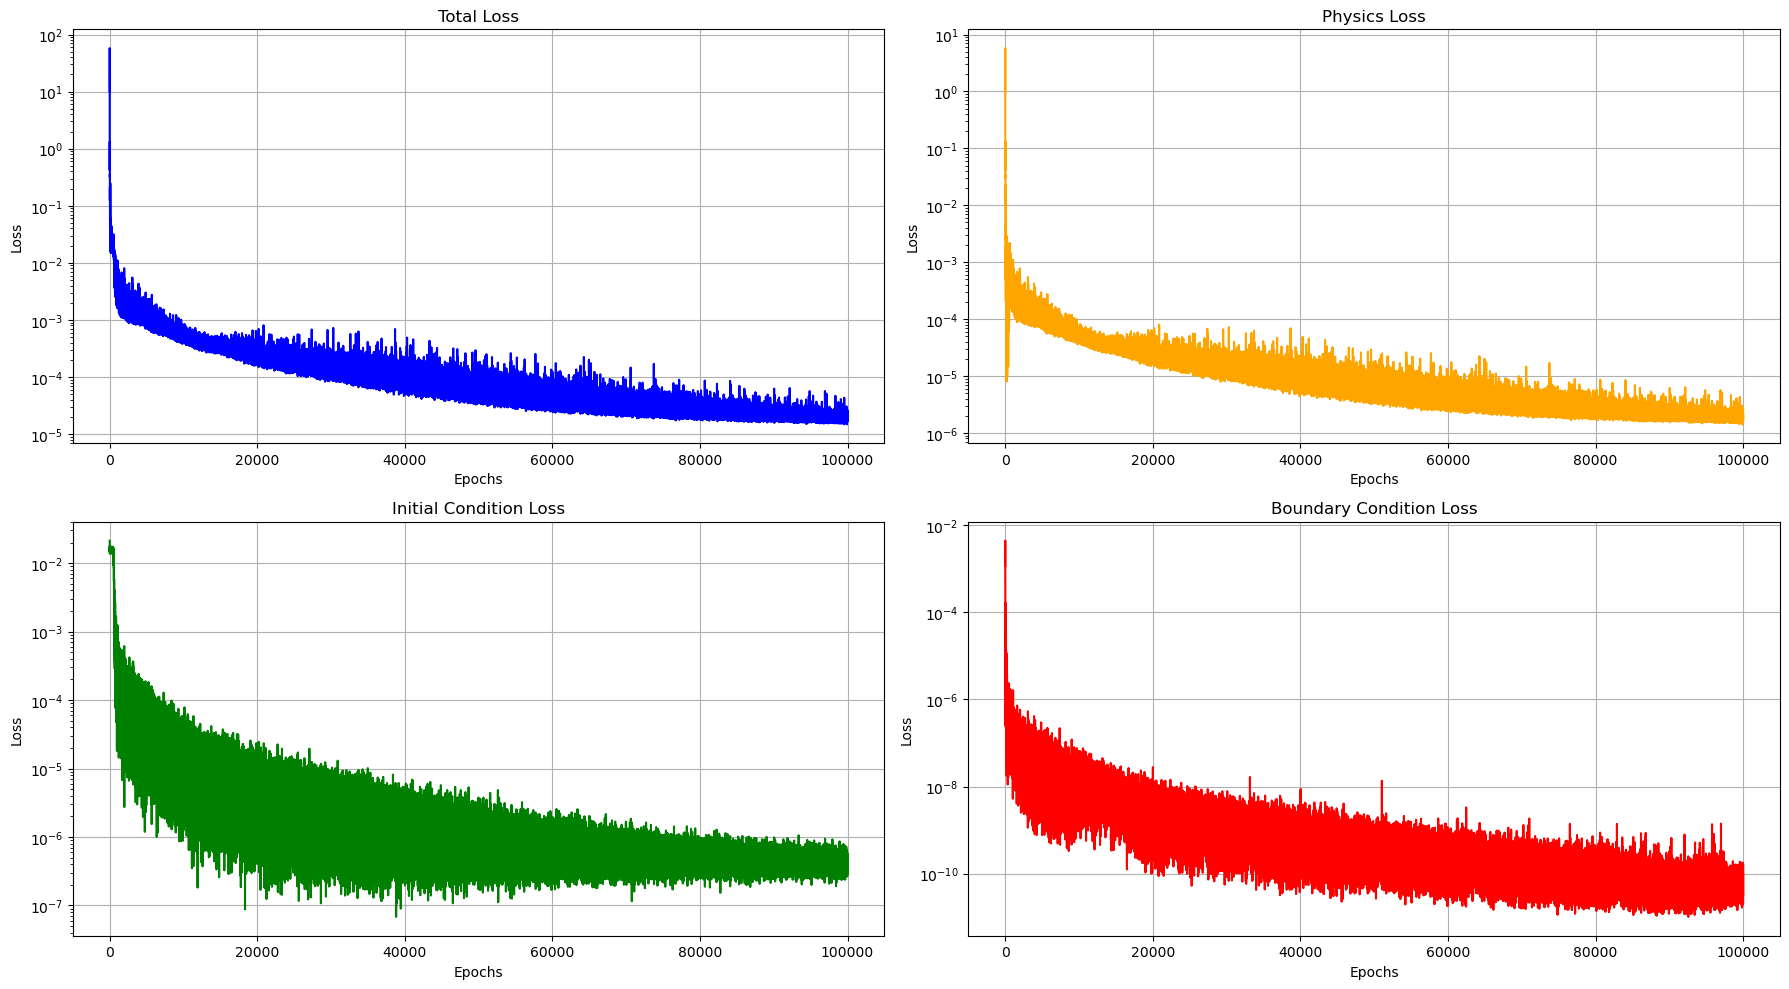

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale("log")

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale("log")

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

In [11]:
Nx = 1000
Nt = 1000

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [12]:
x_values_torch = torch.from_numpy(x_values).float()
t_values_torch = torch.from_numpy(t_values).float()

x_grid, t_grid = torch.meshgrid(x_values_torch, t_values_torch, indexing="ij")

x_flat = torch.reshape(x_grid, [-1])
t_flat = torch.reshape(t_grid, [-1])

psi_real_pinn, psi_img_pinn = model((x_flat, t_flat))

psi_real_pinn = torch.reshape(psi_real_pinn, (Nx, Nt))
psi_img_pinn = torch.reshape(psi_img_pinn, (Nx, Nt))

psi_real_pinn = psi_real_pinn.detach().cpu().numpy()
psi_img_pinn = psi_img_pinn.detach().cpu().numpy()

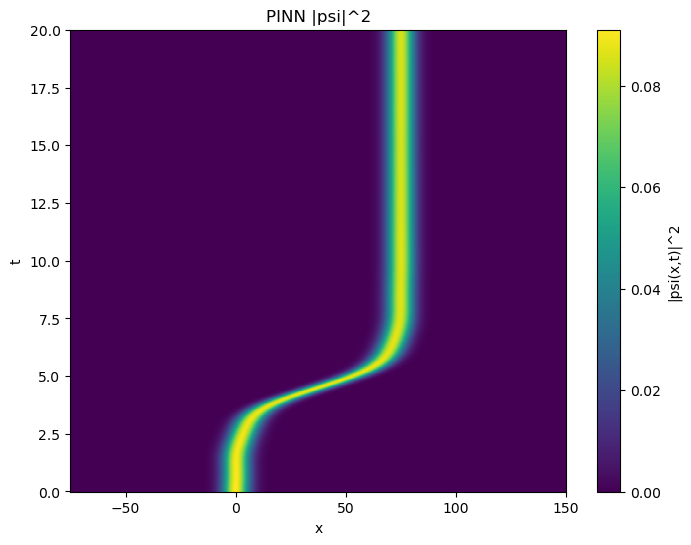

In [13]:
plt.figure(figsize=(8, 6))
psi_sq = psi_real_pinn ** 2 + psi_img_pinn ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN |psi|^2')
plt.show()

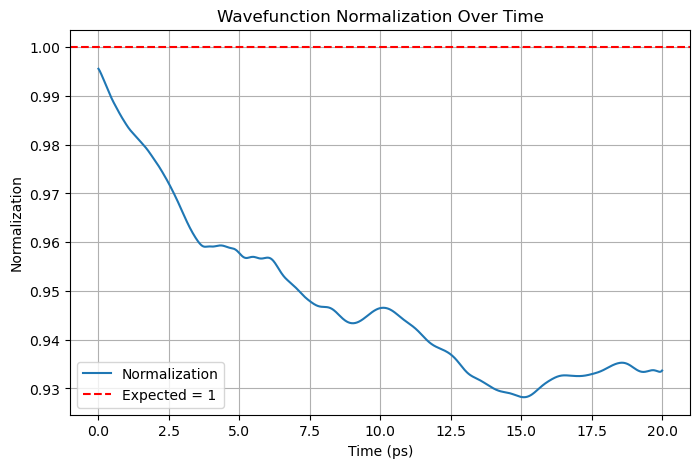

In [14]:
from scipy.integrate import simpson

norms = []

for i in range(1000):
    psi_sq = psi_real_pinn[:, i] ** 2 + psi_img_pinn[:, i] ** 2
    normalization = simpson(psi_sq, x=x_values)
    norms.append(normalization)

plt.figure(figsize=(8,5))
plt.plot(t_values, norms, '-', label='Normalization')
plt.axhline(1.0, color='red', linestyle='--', label='Expected = 1')
plt.xlabel('Time (ps)')
plt.ylabel('Normalization')
plt.title('Wavefunction Normalization Over Time')
plt.legend()
plt.grid(True)
plt.show()